<hr style="border:2px solid gray">

##### Author  : SIVA VIKNESH
##### Email   : siva.viknesh@sci.utah.edu / sivaviknesh14@gmail.com
##### Address : SCI INSTITUTE, UNIVERSITY OF UTAH, SALT LAKE CITY, UTAH, USA
<hr style="border:2px solid gray">

In [1]:
import numpy as np
import torch
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import os
import math
import itertools
from matplotlib import rcParams
import matplotlib.ticker as plticker
from mpl_toolkits.mplot3d import Axes3D
rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]


np.set_printoptions(threshold=np.inf)
np.set_printoptions(suppress=True, precision=15)

Combustion:  <br>
Paper: Symbolic regression via neural networks : 
\
Chemical kinetics with Arrhenius rate dependence


$$
\dot{\alpha} = -k \alpha  e^{1.015\theta} + \mu
$$

$$
\dot{\theta} = \alpha e^{1.025\theta} - \theta
$$

Parameters: \\(k\\), \\(\mu\\)

<Figure size 1200x800 with 0 Axes>

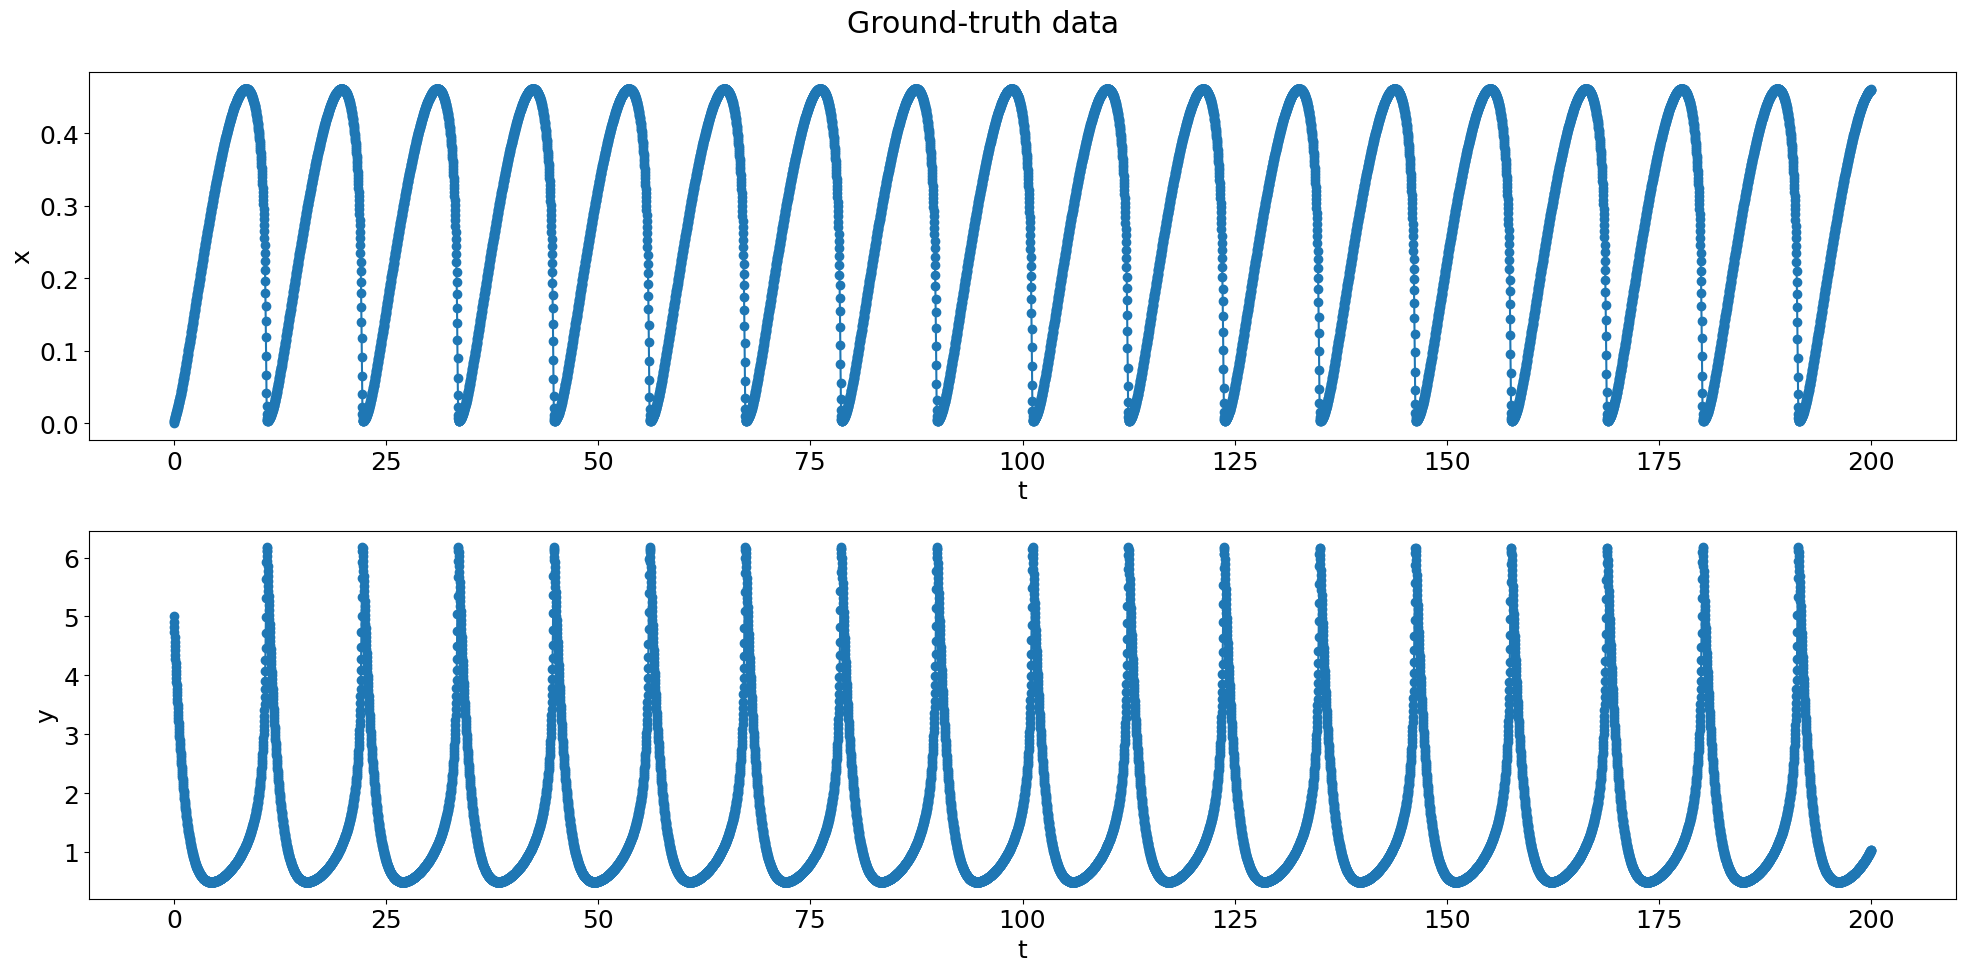

In [2]:
k = 0.07
mu = 0.1
a  = 1.015
b  = 1.025

def deriv(X, t, a, b, k, mu):
    x, y = X
    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y
    return [dxdt, dydt]

# Initial conditions
X0 = [0.0, 5.0]

# Time points
t = np.linspace(0, 200, 10000)

# Integrate the equations
X = odeint(deriv, X0, t, args=(a,b,k,mu))

# Extract the results
x = X[:, 0]
y = X[:, 1]

# Plotting the results
fig = plt.figure(figsize=(12, 8))

fig, ax = plt.subplots(nrows = 2, ncols = 1, figsize =(20, 10))
fig.suptitle('Ground-truth data')

ax[0].plot(t, x, '-o')
#ax[0].set_title('$x$')
ax[0].set(xlabel="t",ylabel="x")

ax[1].plot(t, y, '-o')
#ax[1].set_title('$y$')
ax[1].set(xlabel="t",ylabel="y")

fig.tight_layout()
plt.show()


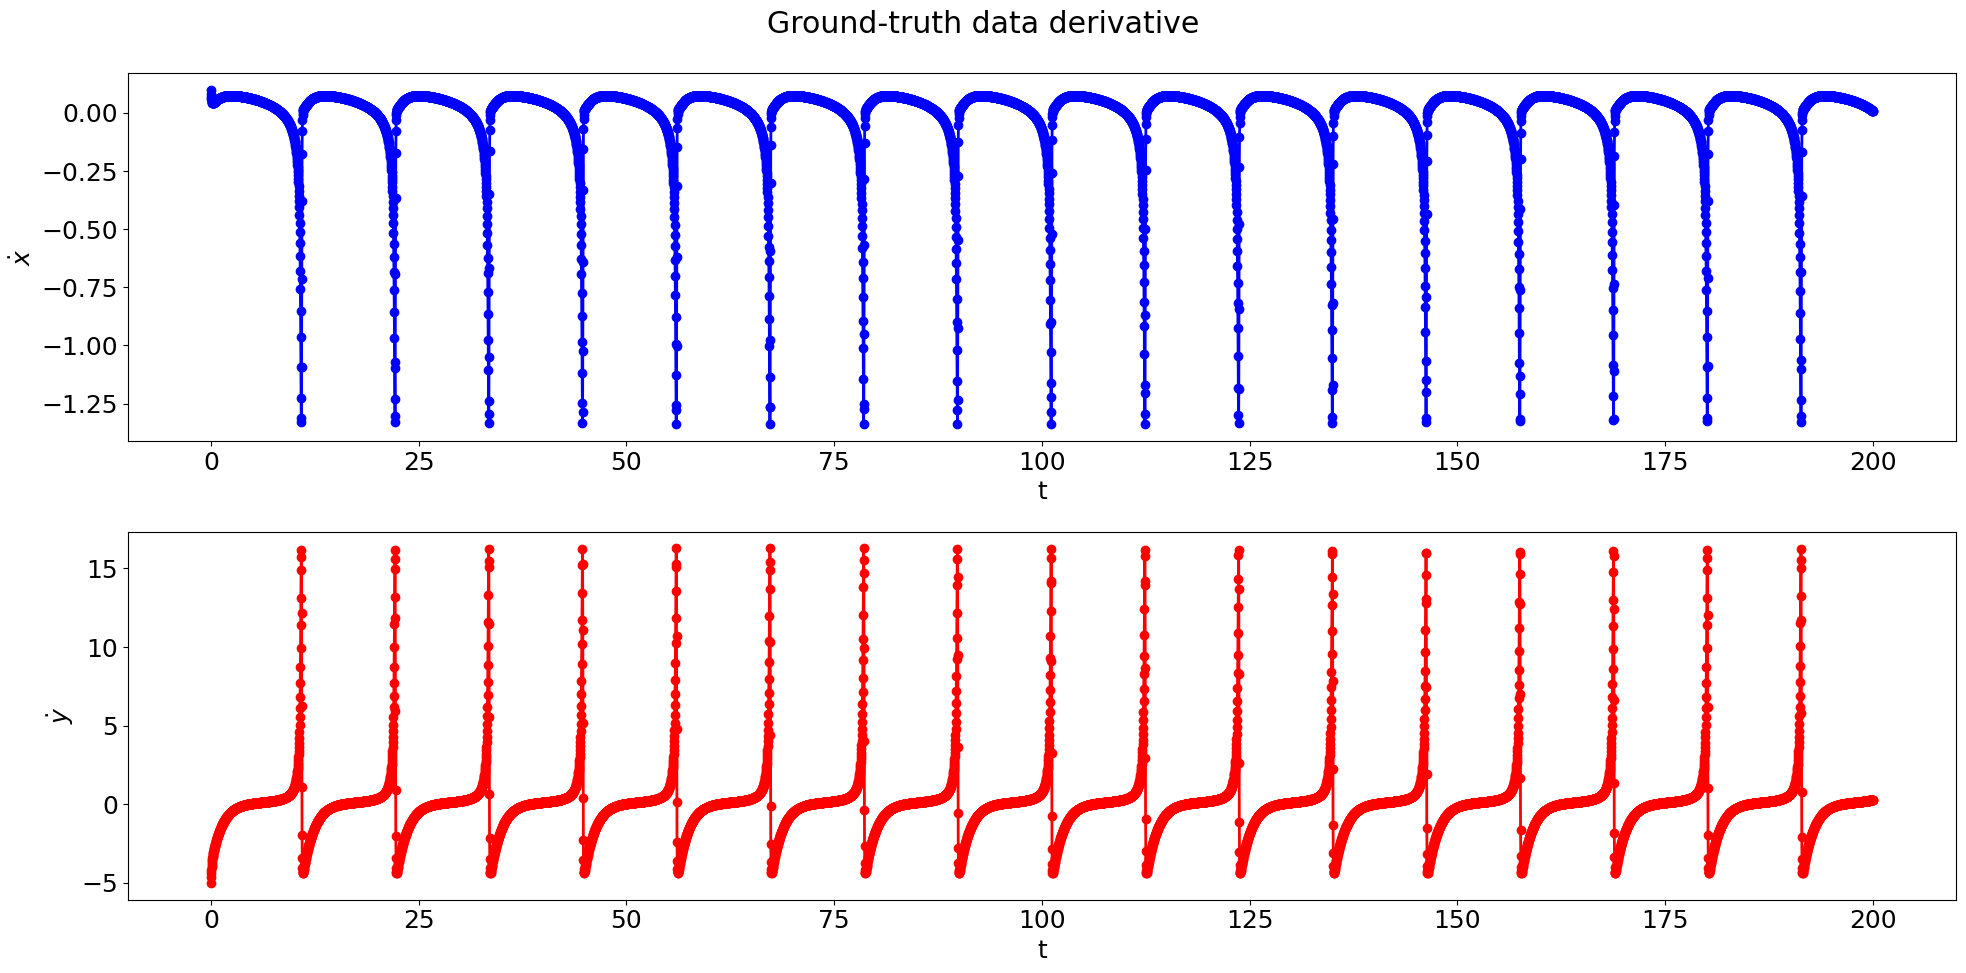

In [3]:
def DERIVATIVE(x,y,a,b,k,mu):

    dxdt = -k*x*np.exp(a*y) + mu
    dydt = x*np.exp(b*y) - y

    return np.vstack((dxdt, dydt)).T

A1A2_time_deriv = DERIVATIVE ( x, y, a, b, k, mu)

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
fig.suptitle('Ground-truth data derivative')

# Plot dA/dt
ax[0].plot(t, A1A2_time_deriv[:, 0], '-o', color='blue', linewidth=2)
ax[0].set(xlabel="t", ylabel=r"$\dot{x}$")

# Plot dP/dt
ax[1].plot(t, A1A2_time_deriv[:, 1], '-o', color='red', linewidth=2)
ax[1].set(xlabel="t", ylabel=r"$\dot{y}$")


fig.tight_layout()
plt.show()

In [4]:
## SINDy Function Definitions
def poolData(yin,nVars,polyorder, p_start, p_increment):
    n = yin.shape[0]
    yout = np.zeros((n,1))

    # poly order 0
    yout[:,0] = np.ones(n)

    max_power = polyorder
    powers = np.arange(p_start, max_power + p_increment , p_increment)

    index_1 = np.where(powers >= 1)[0][0]
    if polyorder >= 2:
      index_2 = np.where(powers >= 2)[0][0]
    if polyorder >= 3:
      index_3 = np.where(powers >= 3)[0][0]

    # poly order 1
    for p in powers[:index_1+1]:
      for i in range(nVars):
          yout = np.append(yout, (np.sign(yin[:, i]) * np.abs(yin[:, i])**p).reshape((yin.shape[0], 1)), axis=1)

    # poly order 2
    if polyorder >= 2:
        for p in powers[ index_1+1 : index_2+1 ] / 2.0 :
            for i in range(nVars):
                for j in range(i, nVars):
                    yout = np.append(yout, ((np.sign(yin[:, i]) * np.abs(yin[:, i])**p) * (np.sign(yin[:, j]) * np.abs(yin[:, j])**p)).reshape((yin.shape[0], 1)), axis=1)

    # poly order 3
    if polyorder >= 3:
        for p in powers[ index_2+1 :  ] /3.0 :
            for i in range(nVars):
                for j in range(i, nVars):
                    for k in range(j, nVars):
                        yout = np.append(yout, ((np.sign(yin[:, i]) * np.abs(yin[:, i])**p) * (np.sign(yin[:, j]) * np.abs(yin[:, j])**p) * (np.sign(yin[:, k]) * np.abs(yin[:, k])**p)).reshape((yin.shape[0], 1)), axis=1)


    return yout

def sparsifyDynamics(Theta,dXdt,lamb,n): #Solves SINDy's L1 regularized convex optimization problem
    Xi = np.linalg.lstsq(Theta,dXdt,rcond=None)[0] # Initial guess: Least-squares

    for k in range(10):
        smallinds = np.abs(Xi) < lamb # Find small coefficients
        Xi[smallinds] = 0                          # and threshold
        for ind in range(n):                       # n is state dimension
            biginds = smallinds[:,ind] == 0
            # Regress dynamics onto remaining terms to find sparse Xi
            Xi[biginds,ind] = np.linalg.lstsq(Theta[:,biginds],dXdt[:,ind],rcond=None)[0]

    return Xi

In [5]:
# POLYNOMIAL TERMS
p_maxorder = 2.0  # Maximum order of the polynominal
p_start = 1.0  # Starting power for the polynominal
p_increment = 1.0  # Increment for the polynominal

poly_candidate  = poolData(X, 2, p_maxorder, p_start, p_increment)
poly_candidate_exp = poly_candidate [:, 1:] # IGNORING THE CONSTANT - FIRST COLUMN !!!

# Define the powers
x_exp_powers = [ 1.015, 2.0]
y_exp_powers = [ 1.025, 2.0]

# Calculate x and y to their respective powers
x_exp_powered = np.array([ np.exp(x * p) for p in x_exp_powers])
y_exp_powered = np.array([ np.exp(y * p) for p in y_exp_powers])

# Combine poly_candidate with x_exp_powered and y_exp_powered to get x*exp(x), x*exp(y), y*exp(x), and y*exp(y)
x_exp_combination = np.concatenate([poly_candidate_exp * x_exp[:, None] for x_exp in x_exp_powered], axis=1)
y_exp_combination = np.concatenate([poly_candidate_exp * y_exp[:, None] for y_exp in y_exp_powered], axis=1)

# Combine all exponential terms using np.hstack
all_exp_combinations = np.hstack([x_exp_combination, y_exp_combination])

All_candidates       = np.hstack(( poly_candidate, all_exp_combinations ))


**Considering all the candidates in the optimization**

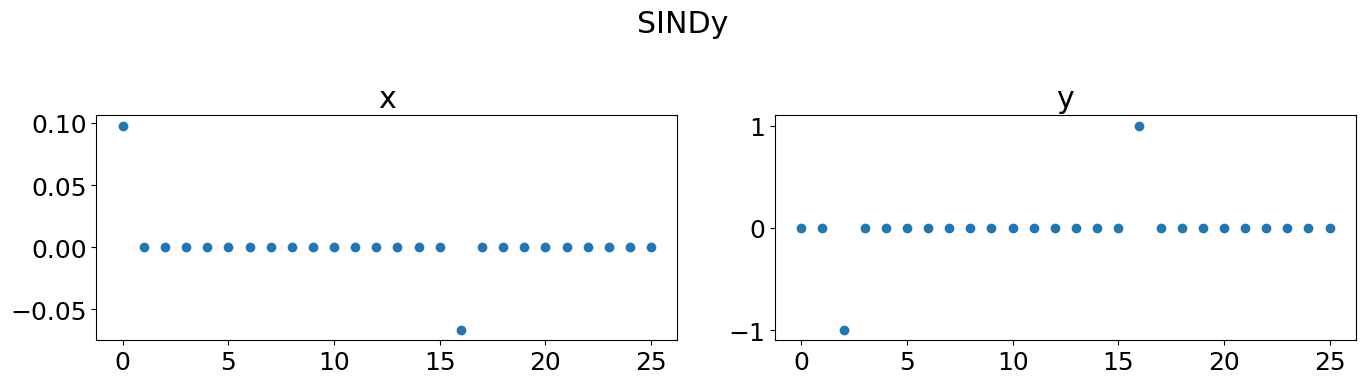

[[ 0.097887756471926 -0.066772853846566]]
[[-1.  1.]]


In [8]:
lamb = 0.01 # sparsification knob lambda
coeff_matrix = sparsifyDynamics(All_candidates, A1A2_time_deriv, lamb, 2)
#****************************************************************************#
loc = plticker.MultipleLocator(base=3) # this locator puts ticks at regular intervals
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize =(14, 4))
fig.suptitle('SINDy')

ax[0].plot(coeff_matrix [:, 0], 'o')
ax[0].set_title('x')

ax[1].plot(coeff_matrix [:, 1], 'o')
ax[1].set_title('y')

fig.subplots_adjust(top=0.8)
fig.tight_layout()
plt.show()

print(coeff_matrix[np.nonzero(coeff_matrix[:, 0]), 0])
print(coeff_matrix[np.nonzero(coeff_matrix[:, 1]), 1])